In [1]:
import sys, os
sys.path.append("./dataset")

import numpy as np
import pickle
from dataset.mnist import load_mnist
import matplotlib.pylab as plt

In [2]:
def step_function(x):
    return np.array(x > 0, dtype=np.int)

In [3]:
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))

In [4]:
def relu(x):
    return np.maximum(0, x)

In [5]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [6]:
def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

In [8]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [9]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))

In [10]:
def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [11]:
def numerical_gradient(f, x) :
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()
        
    return grad

In [12]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.count = 0
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
        
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x, t) # 함수
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        #forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        #backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis = 0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)
        
        return grads

In [13]:
net = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [14]:
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 50)
(50,)
(50, 10)
(10,)


In [15]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [16]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

In [17]:
print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 50)
(50,)
(50, 10)
(10,)


In [18]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
train_loss_list = []

iters_num = 10000
train_size = x_train.shape[0]
print(x_train.shape)
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

(60000, 784)


In [19]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [20]:
for i in range(iters_num) :
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        print("loss: " + str(loss))

loss: 227.45965372765272
loss: 87.8656792467344
loss: 45.990585300388595
loss: 30.273029765773963
loss: 47.06148862397865
loss: 40.76327190387733
loss: 27.84921384882247
loss: 34.02256863132159
loss: 28.857596071455742
loss: 14.7118633946976
loss: 26.25067872513172
loss: 20.141441147190175
loss: 12.434340456283934
loss: 22.585280161279073
loss: 16.999411934803724
loss: 19.234772213466986
loss: 23.20491476819868


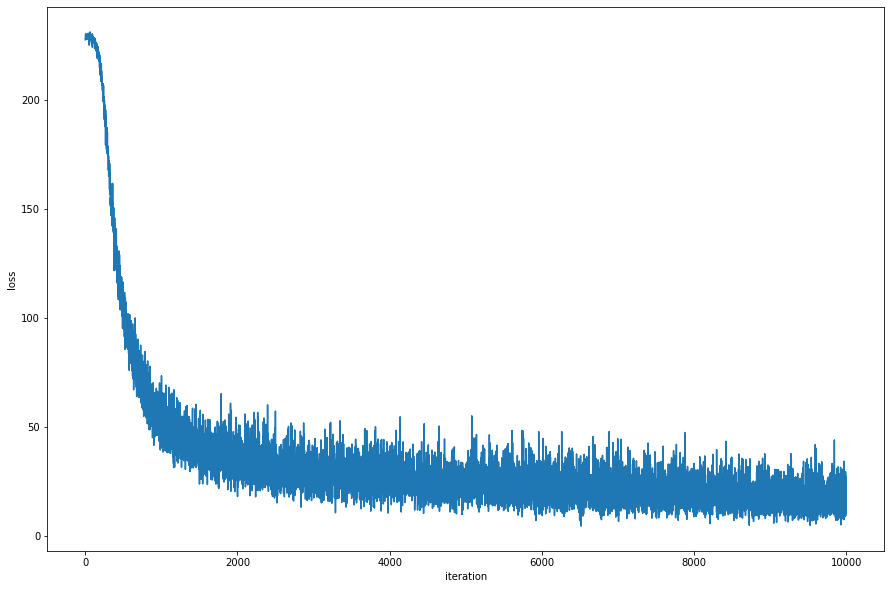

In [21]:
x = np.arange(len(train_loss_list))

plt.figure(figsize=(15,10))
plt.plot(x, train_loss_list, label="train acc")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [22]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

In [23]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [24]:
for i in range(iters_num) :
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2') :
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('loss: ' + str(loss) + ', train acc: ' + str(train_acc) + ', test acc: ' + str(test_acc))

loss: 228.80844837384618, train acc: 0.09871666666666666, test acc: 0.098
loss: 80.86566364768996, train acc: 0.7846166666666666, test acc: 0.7903
loss: 42.40791192471137, train acc: 0.8783833333333333, test acc: 0.8806
loss: 27.88852485808929, train acc: 0.8982166666666667, test acc: 0.9019
loss: 40.07429878547969, train acc: 0.9081, test acc: 0.9102
loss: 31.829691983643915, train acc: 0.9153666666666667, test acc: 0.9173
loss: 18.233087950517206, train acc: 0.9206, test acc: 0.9206
loss: 24.60971253525568, train acc: 0.9246, test acc: 0.9249
loss: 16.263299547502246, train acc: 0.92825, test acc: 0.9282
loss: 17.328819382905984, train acc: 0.9310666666666667, test acc: 0.9321
loss: 27.704480524600886, train acc: 0.9345, test acc: 0.9355
loss: 27.091500851772402, train acc: 0.9371833333333334, test acc: 0.9377
loss: 21.111542220355492, train acc: 0.9391166666666667, test acc: 0.9388
loss: 16.970460180878366, train acc: 0.9410333333333334, test acc: 0.9412
loss: 20.403274108686645, tr

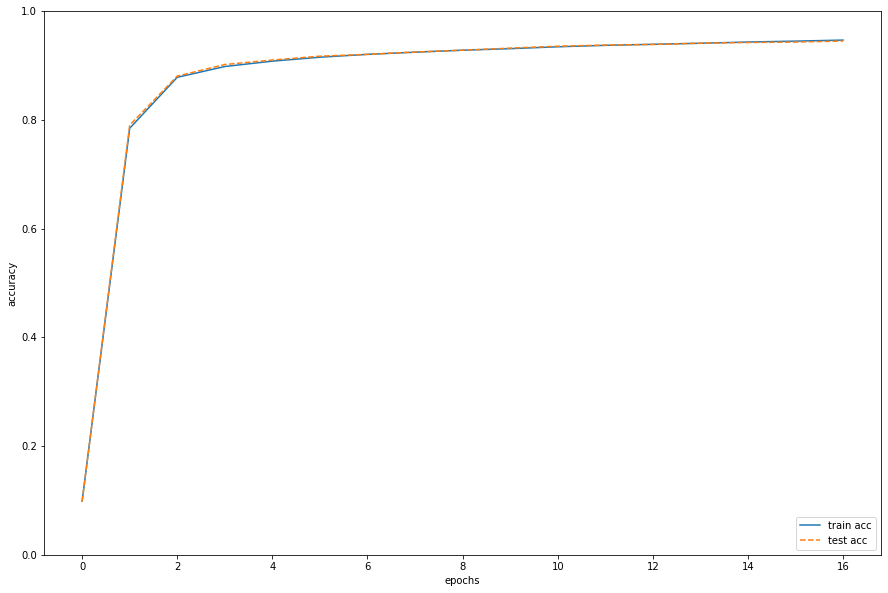

In [25]:
markers = {'train': 'o', 'test' : 's'}
x = np.arange(len(train_acc_list))

plt.figure(figsize = (15, 10))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()